In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as ss
import scikit_posthocs as sp
from pingouin import friedman
import Orange

C:\Users\vhsm9\anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.11, the latest is 0.5.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
def best_parameters(texture_selector, num_textures, features_set, feature_selector,
                    feature_reduction, classifier, friedman_plot=True):
    
    
    filename_open = 'results_training'
    
    if texture_selector == 'ALL':
        filename_open += '_all'
    elif texture_selector == 'LINSPACE':
        filename_open += f'_linspace_{num_textures}'
        
    filename_open += f'_{features_set}'
        
    if feature_selector == '':
        pass
    else:
        filename_open += f'_{feature_selector}'
    
    if feature_reduction == '':
        pass
    else:
        filename_open += f'_{feature_reduction}'
        
    filename_open += f'_{classifier}.pkl'
    
        
    with open(filename_open, 'rb') as f:
        data = pickle.load(f)
        
    # Choosing the best parameter:

    df_val_score = pd.DataFrame(data).T

    print(round(df_val_score.mean()*100,2))

    matrix_analysis = df_val_score.to_numpy()
    labels = list(df_val_score.columns)

    # Friedman Test
    
    if friedman_plot == True:  
        
        print('Friedman Test:\n')
        print('Option #1:')
        print(ss.friedmanchisquare(*matrix_analysis.T))

        print('\nOption #2:')
        
        df_matrix_analysis = pd.DataFrame(matrix_analysis, columns=labels)
        df_matrix_analysis['respID'] = range(1,len(df_matrix_analysis)+1)
        longDf = pd.melt(df_matrix_analysis, id_vars='respID', var_name='item', value_name='score')
        pgRes = friedman(data=longDf, dv='score', within='item', subject='respID')
        display(pgRes)

        # Post Hoc - Nemenyi Test (p-values):

        print('\nPost Hoc - Nemenyi (p-values):')
        pc = sp.posthoc_nemenyi_friedman(df_matrix_analysis.drop(['respID'],axis=1))
        display(pc)
        cmap = ['1', '#fb6a4a',  '#08306b',  '#4292c6', '#c6dbef']
        heatmap_args = {'cmap': cmap, 'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
        sp.sign_plot(pc, **heatmap_args)
        plt.show()


    # Average Rank + CD Diagram:

    rank_matrix = []

    for line in range(0, matrix_analysis.shape[0]):
        rank_matrix.append(ss.rankdata(-matrix_analysis[line,:]))

    rank_matrix = np.array(rank_matrix)
    avranks = rank_matrix.mean(axis=0)

    cd = Orange.evaluation.compute_CD(avranks,100,alpha='0.05', test='nemenyi') #tested on 100 experiments
    Orange.evaluation.graph_ranks(avranks, labels, cd=cd, width=10, textspace=1.5)
    print(f'CD Diagram (CD = {cd:.2f}):')
    plt.show()
    
    return

{'fs': 'manual', 'percentile': 100, 'fr': 'N', 'max_iter': 1000, 'C': 0.01}    80.28
{'fs': 'manual', 'percentile': 100, 'fr': 'N', 'max_iter': 1000, 'C': 0.1}     80.47
{'fs': 'manual', 'percentile': 100, 'fr': 'N', 'max_iter': 1000, 'C': 1}       80.51
{'fs': 'manual', 'percentile': 100, 'fr': 'N', 'max_iter': 1000, 'C': 10}      80.53
{'fs': 'manual', 'percentile': 100, 'fr': 'N', 'max_iter': 1000, 'C': 100}     80.53
dtype: float64
CD Diagram (CD = 0.61):


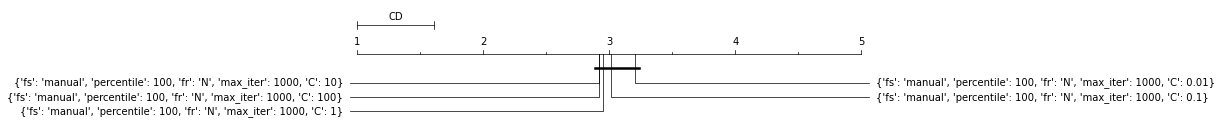

In [10]:
best_parameters(texture_selector = 'LINSPACE',
                num_textures = 20,                   
                features_set = 'delta_stats',         #['baseline', 'delta', 'stats', 'delta_stats', ...]
                feature_selector = 'manual',
                feature_reduction = '',
                classifier = 'svm-linear',            #['logistic', 'knn', 'svm', 'rf', 'lgboost', ...]
                friedman_plot = False)